# CNN MODEL FOR CAPSTONE 

In [ ]:
# importing libraries 

import matplotlib.pyplot as plt
import numpy as np
import os, glob
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import pathlib





# Loading dataset 

In [ ]:

path = "drive/MyDrive/CNN_Model/dataset/"

dataDirectory = pathlib.Path(path)

# defining some parameters 
height =160
width = 160 

# training dataset,  80% of the images for training and 20% for validation.
train_set = tf.keras.preprocessing.image_dataset_from_directory (dataDirectory, labels='inferred', 
                                                                shuffle=True,batch_size=32,
                                                                #label_mode="binary",
                                                                validation_split=0.2,  seed=123,
                                                                subset="training",
                                                                image_size=(height,width))

# validation  dataset 
validation_set = tf.keras.preprocessing.image_dataset_from_directory (dataDirectory, labels='inferred', 
                                                                shuffle=True,batch_size=32,
                                                                #label_mode="binary",
                                                                validation_split=0.2,seed=123,
                                                                subset="validation",
                                                                 image_size=(height,width))

#glob.glob(path + "*/*",recursive=True)
#PIL.Image.open(str(data_dir[2000]))


Found 2511 files belonging to 2 classes.
Using 2009 files for training.
Found 2511 files belonging to 2 classes.
Using 502 files for validation.


# creating a test set from the validation set 

In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_set)
test_set = validation_set.take(validation_batches // 5)
validation_set = validation_set.skip(validation_batches // 5)

# Configuring the dataset for performance 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=AUTOTUNE)
test_set = test_set.prefetch(buffer_size=AUTOTUNE)

### Data Augumentation 

Data augmentation lets a sample data appear subtly different each time the algorithm processes it. The approach makes each data set look unique to the model and stops the model from understanding the data sets’ characteristics.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Augumentation to the same dataset 


In [ ]:
for image, _ in train_set.take(1):
  plt.figure(figsize=(12, 12))
  first_image = image[10]
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescaling the pixel values of the images - to fix that of GoogleNet - Inception_v3 

In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input 

# Creating the model

### Create the base model from the pre-trained model Inception V3

In [ ]:

IMG_SHAPE = (height,width) + (3,)

base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet',input_shape=IMG_SHAPE
)

87924736/87910968 [==============================] - 0s 0us/step


### freeze base model 

In [ ]:
base_model.trainable =False
#base_model.summary()


### create a new model on top - add a classification head 

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)



##  Build a model by chaining together the data augmentation, rescaling, base_model layers

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### compile model 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

### Train the model 

In [ ]:
first_epochs = 10
loss, accuracy = model.evaluate(validation_set)

print("first loss: {:.2f}".format(loss))
print("first accuracy: {:.2f}".format(accuracy))

13/13 [==============================] - 76s 2s/step - loss: 1.0264 - accuracy: 0.4384
first loss: 1.03
first accuracy: 0.44


In [ ]:
model_b4_finetuning = model.fit(train_set,
                    epochs=first_epochs,
                    validation_data=validation_set)

Epoch 1/10
63/63 [==============================] - 167s 3s/step - loss: 0.1632 - accuracy: 0.9338 - val_loss: 0.1767 - val_accuracy: 0.9187
Epoch 2/10
63/63 [==============================] - 168s 3s/step - loss: 0.1719 - accuracy: 0.9328 - val_loss: 0.1600 - val_accuracy: 0.9261
Epoch 3/10
63/63 [==============================] - 169s 3s/step - loss: 0.1703 - accuracy: 0.9333 - val_loss: 0.1800 - val_accuracy: 0.9360
Epoch 4/10
63/63 [==============================] - 164s 3s/step - loss: 0.1937 - accuracy: 0.9313 - val_loss: 0.1613 - val_accuracy: 0.9212
Epoch 5/10
63/63 [==============================] - 164s 3s/step - loss: 0.1713 - accuracy: 0.9363 - val_loss: 0.1495 - val_accuracy: 0.9360
Epoch 6/10
63/63 [==============================] - 167s 3s/step - loss: 0.1698 - accuracy: 0.9403 - val_loss: 0.1723 - val_accuracy: 0.9286
Epoch 7/10
63/63 [==============================] - 173s 3s/step - loss: 0.1561 - accuracy: 0.9393 - val_loss: 0.1720 - val_accuracy: 0.9236
Epoch 8/10
63

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine Tuninng the model 

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002),
              metrics=['accuracy'])


In [ ]:
fine_tune_epochs = 5
total_epochs =  fine_tune_epochs + first_epochs

model_after_finetuning = model.fit(train_set,
                         epochs=total_epochs,
                         validation_data=validation_set)

Epoch 1/15
63/63 [==============================] - 376s 6s/step - loss: 0.1364 - accuracy: 0.9532 - val_loss: 0.1558 - val_accuracy: 0.9557
Epoch 2/15
63/63 [==============================] - 359s 6s/step - loss: 0.0845 - accuracy: 0.9706 - val_loss: 0.0551 - val_accuracy: 0.9803
Epoch 3/15
63/63 [==============================] - 354s 6s/step - loss: 0.0549 - accuracy: 0.9791 - val_loss: 0.1192 - val_accuracy: 0.9729
Epoch 4/15
63/63 [==============================] - 348s 5s/step - loss: 0.0348 - accuracy: 0.9856 - val_loss: 0.0994 - val_accuracy: 0.9729
Epoch 5/15
63/63 [==============================] - 346s 5s/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.1224 - val_accuracy: 0.9729
Epoch 6/15
63/63 [==============================] - 348s 5s/step - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.1145 - val_accuracy: 0.9631
Epoch 7/15
63/63 [==============================] - 345s 5s/step - loss: 0.0272 - accuracy: 0.9910 - val_loss: 0.1127 - val_accuracy: 0.9729
Epoch 8/15
63

### calculating accuracy of the model 

In [ ]:

# accuracy and loss  before fine tunning the model 
acc = model_b4_finetuning.history['accuracy']
val_acc = model_b4_finetuning.history['val_accuracy']

loss = model_b4_finetuning.history['loss']
val_loss = model_b4_finetuning.history['val_loss']

# accuracy and loss  after fine tunning the model 

acc += model_after_finetuning.history['accuracy']
val_acc += model_after_finetuning.history['val_accuracy']

loss += model_after_finetuning.history['loss']
val_loss += model_after_finetuning.history['val_loss']

loss, accuracy = model.evaluate(test_set)
print('Test accuracy :', accuracy)


3/3 [==============================] - 10s 2s/step - loss: 0.1828 - accuracy: 0.9688


### Make prediction based on passed input 

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyjvgna8r/assets


In [ ]:

from tflite_model_maker.config import ExportFormat
model.export(export_dir='drive/MyDrive/CNN_Model/dataset/', export_format=ExportFormat.LABEL)

ModuleNotFoundError: ignored

Predictions:
 [1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1]
Labels:
 [1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1]


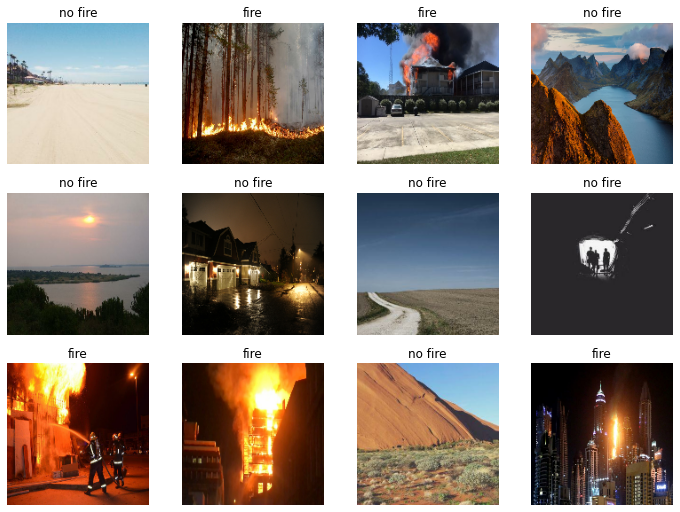

In [ ]:
# get batch of images from the test set

class_names =  ["fire","no fire"]
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid -  model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.4, 0, 1)


print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(12):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

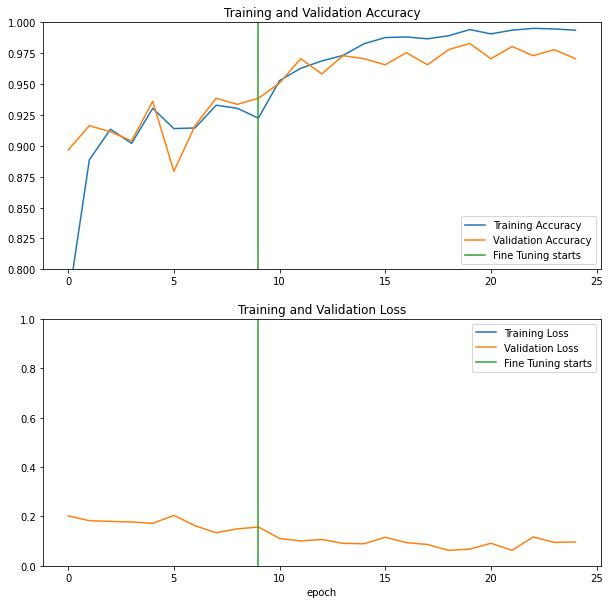

In [ ]:
# plotting the graphs 

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([first_epochs-1,first_epochs-1],
          plt.ylim(), label='Fine Tuning starts ')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([first_epochs-1,first_epochs-1],
         plt.ylim(), label='Fine Tuning starts')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprnjl687w/assets
